# Code for Processing Multistage Data Collected in Centurion Lab

## Global Variable Usage
The package gued relies on a few global variables which should be optimized for each experiment. The global variables are stored in gued_globals.py and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [1]:
%%writefile gued_globals.py
### Global Variables for IR CF3I data set

# Variable for reading files
SEPARATORS = ['-', '_']

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3
THRESHOLD = 4500

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [545, 495]
MASK_RADIUS = 45
ADDED_MASK = []
# Rectangular Mask Details. If not needed just ignore
REC_LENGTH = 535 # start position of rectangle within the image
REC_EXTENT = (540, 30) # (length, width) # Use () not []

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using
# std_factor = 4
STD_FACTOR = 2

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package

PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/ding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/


Overwriting gued_globals.py


## Import Packages

In [2]:
import numpy as np
import glob 
import matplotlib.pyplot as plt
from datetime import date

#new code
import gued 

# interactive plotting
%matplotlib widget

## Import all images

In [3]:
help(gued.get_image_details_keV)

Help on function get_image_details_keV in module gued:

get_image_details_keV(file_names, sort=False, multistage=False, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    multistage (boolean):
        default is set to False. Use this when file names contain information from multiple stages.
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean): 
        default is set to False. When True, code prompts you for a minimum and maximum value then
        returns only the information from files within this range
    
    RETURN

Path to images  C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\UV_IR_exp\07222024\Time_Scans\Scan 2\\Image_*.tiff
Number of files loaded:  300
Load diffraction signal
sorting based on UV stage position


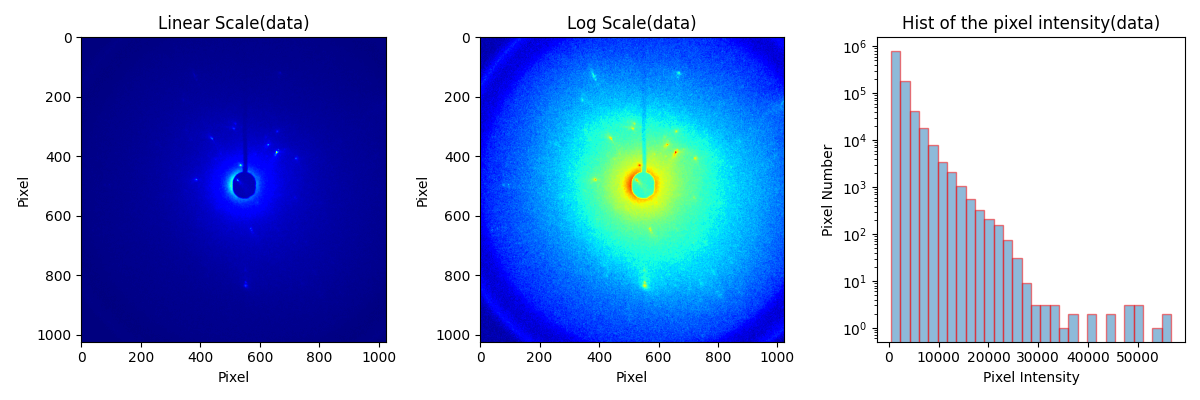

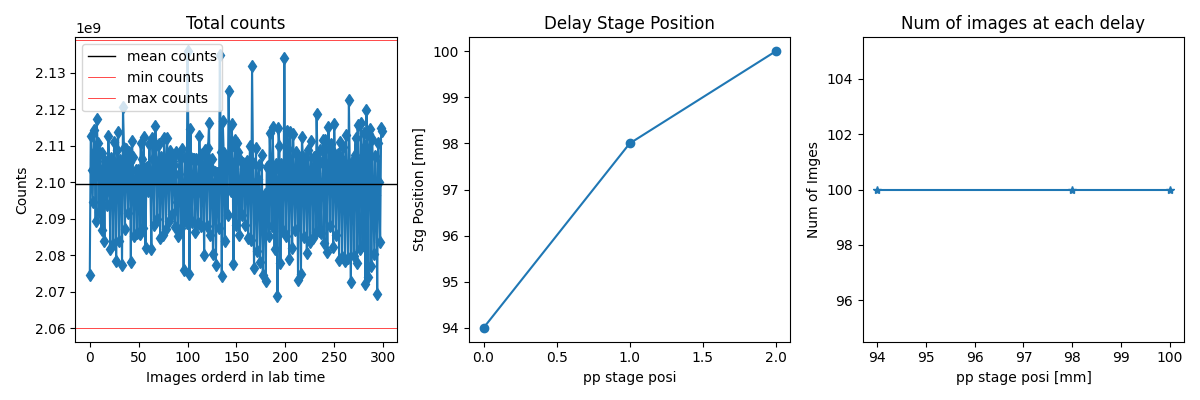

Image number read:  300
Stage positions:  3
100


In [4]:
# Using glob and * place holders to read in all file names from the specified path
data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\UV_IR_exp\\07222024\\Time_Scans\\Scan 2\\'
run_path = "\\Image_*.tiff"

#bkg_path = '\\work\\centurion\\shared\\UED_data\\FY18_o-nitrophenol\\20180823\\Background\\*\\*\\ANDOR1_*.tif'

full_path = data_path + run_path
print("Path to images ", full_path)
#print("Path to background images ", bkg_path)

files = glob.glob(full_path)
#bkg_files = glob.glob(bkg_path)
print("Number of files loaded: ", len(files))
#print("Number of background files loaded: ", len(bkg_files))


print('Load diffraction signal');
data_array, stage_positions, file_order, counts, _ = gued.get_image_details_keV(files[:], sort=True, multistage=True, filter_data=False, plot=True)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(len(np.unique(file_order)))

## Apply Background or Reference Images

In [5]:
ref_sign = 'no'    
bkg_sign = 'no'

if ref_sign == 'yes':
    ref_data, ref_ir, ref_uv, ref_files, ref_counts, ref_current = gued.get_image_details_keV(ref_files)
    ref_stage = np.zeros(len(ref_data))
    stage_positions = np.concatenate((stage_positions, ref_stage))
    test_data = np.concatenate((test_data, ref_data))
    counts = np.concatenate((counts, ref_counts))
    current = np.concatenate((current, ref_current))
    
if bkg_sign == 'yes':
    test_data = test_data - bkg_dlys_ave


## Remove Images with Bad Counts

In [6]:
help(gued.remove_counts)

Help on function remove_counts in module gued:

remove_counts(data_array, stage_positions, file_order, counts, added_range=[], std_factor=2, plot=False)
    Filters input parameters by removing any data where the total counts falls outside of the set filter. Default
    value is set to 3 standard deviations from the mean. Returns the same variables as it inputs but with
    different dimensions.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        Multidimensional array of N x 1024 x 1024 where N is the length of file_names list
    stage_pos (array): 
        One dimensional array of length N containing the stage positions associated with each image.
    file_order (array): 
        One dimensional array of length N that reflects the order with which the images are taken.
    counts(ndarray): 
        One dimensional array of length N containing the total counts after summing over each array
        element.
    
    OPTIONAL ARGUMENTS:
    
    std_factor (int): 
        Defau

9  number of files removed from  300  initial files


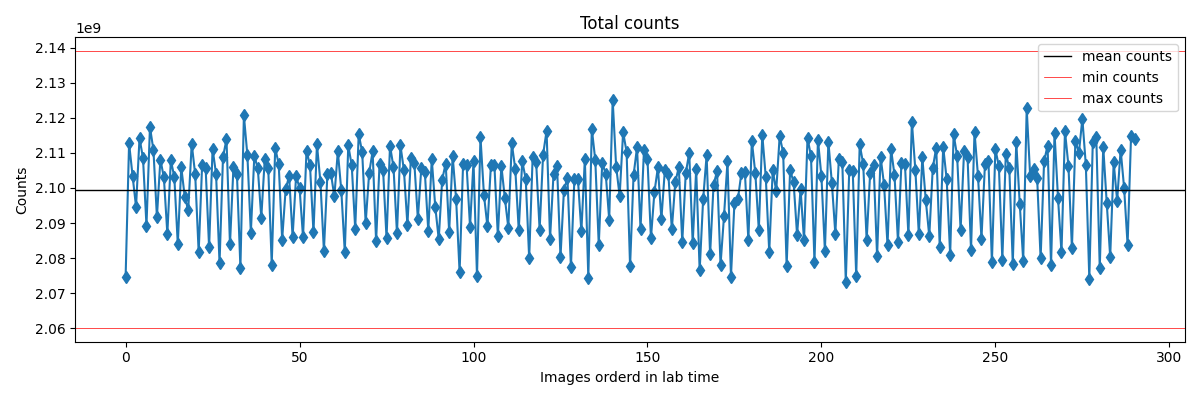

In [7]:
# Remove Outlier Images Based on Total Counts # TODO need to update this to allow for more variables
data_array, stage_positions, file_order, counts = gued.remove_counts(data_array, stage_positions, file_order, counts, added_range=[], plot=True)


## Average Based on Stage Positions

In [8]:
stage_len = len(uni_stage);               #  Number of delays
ave_data = np.ones((stage_len,1024,1024));  # temporary array to be filled in


if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print(f'Averaging data at stage posi # {uni_stage[i]}') # Obtain a sub array to save the data in one delay
    stage_data = data_array[np.where(stage_positions==uni_stage[i])[0]]
    ave_data[i] = np.nanmean(stage_data,axis=0) #assign values to array

data_array = ave_data # renaming for ease and continuity
print(data_array.shape)

Averaging data at stage posi # 94.0
Averaging data at stage posi # 98.0
Averaging data at stage posi # 100.0
(3, 1024, 1024)


## Subtract Background

In [9]:
help(gued.remove_background_pool)

Help on function remove_background_pool in module gued:

remove_background_pool(data_array, remove_noise=True, plot=False)
    Removes the background of images based on the corners. Runs the hidden function _remove_background and runs it in parallel.
    
    ARGUMENTS:
    
    data_array (3d array): 
        data array of all images
    
    OPTIONAL ARGUMENTS:
    
    remove_noise (boolean): 
        Default set to true. Returns data array with noise removed. If false, only returns the interpolated background
    plot (boolean): 
        Default set to false. When true, plots an example of original data, interpolated background, and cleaned image.
    
    RETURNS:
    
    clean_data (3d array): 
        Original data with background removed when remove_noise==True
    or
    backgrounds (3d array):
        Interpolated background for each image when remove_noise==False



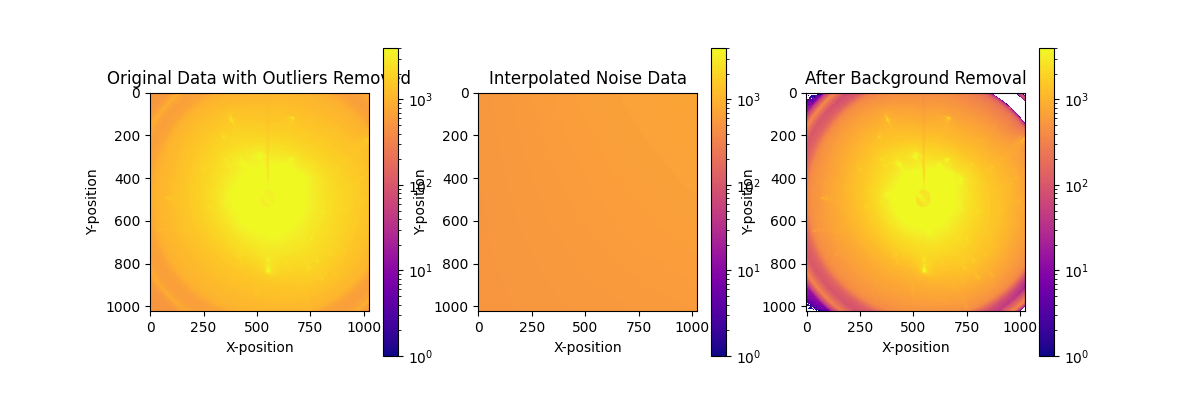

In [10]:
data_array = gued.remove_background_pool(data_array, remove_noise=True, plot=True)

## Remove Hot Pixels

In [11]:
help(gued.remove_xrays_pool)

Help on function remove_xrays_pool in module gued:

remove_xrays_pool(data_array, plot=False, return_pct=False, std_factor=2)
    Filters out any pixels that are more than set threshold value based on the standard deviation of the
    average pixel value by running the hidden function _remove_xrays in parallel.
    
    ARGUMENTS:
    
    data_array (3d array): 
        array of image like data with length N where N is number of images.
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default set to True. Plots the percentage of pixeled removed during cleaning process
    return_pct (boolean):
        Default is set to False. When true, returns the pct removed along with the clean_data
    std_factor (int): 
        Default set to 3. Defines the threshold for removing pixels with |pixel_value - mean| > std_factor*std
    
    RETURNS:
    
    clean_data (3d array): 
        array of image like data with shape of input data array where errant pixels are now masked based 

Removing hot pixels from all data


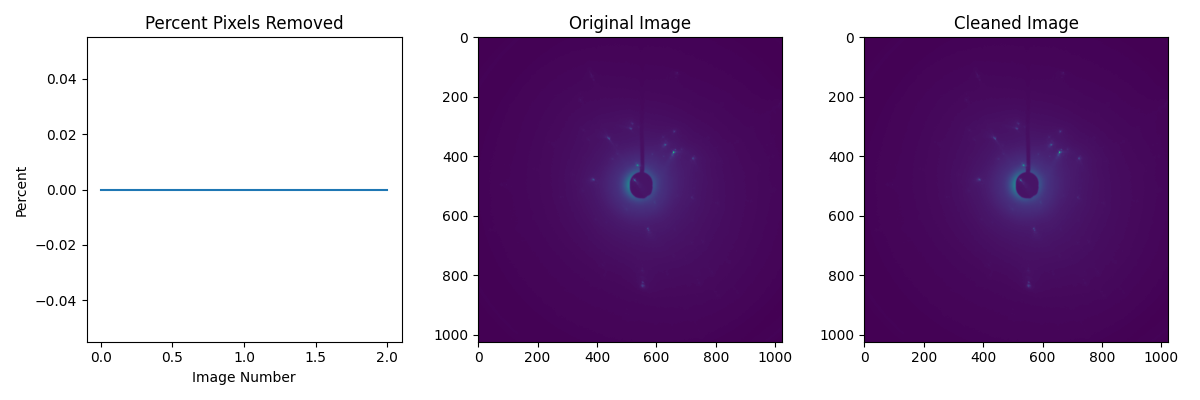

In [12]:
data_array = gued.remove_xrays_pool(data_array, plot=True, return_pct=False)

## Mask Beam Block and Artifacts


In [13]:
help(gued.apply_mask)

Help on function apply_mask in module gued:

apply_mask(data_array, fill_value=nan, add_rectangular=False, plot=False, print_vals=False)
    Applies a mask to individual images in the data array.
    
    ARGUMENTS:
    
    data_array (array):
        2D or 3D array of an image or images.
    
    OPTIONAL ARUGMENTS:
    
    fill_value (int, float, or nan):
        Default set to np.nan. Value used to fill the area of the mask.
    add_rectangular (boolean)
        The default is True. Adds an additional mask with rectangular shape. 
    plot (boolean):
        Default set to False. When true, plots a figure with the original data, the masked data, and a contour map of the data
    print_vals (boolean):
        Default set to False. When true, prints the values at each contour line. Useful for setting global variables
    
    GLOBAL VARIABLES:
    
    MASK_CENTER : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscattered electron b

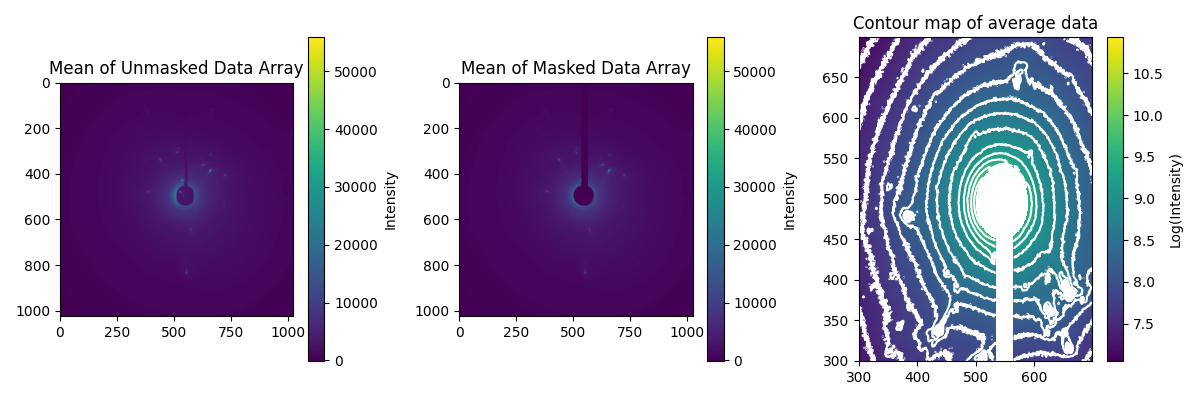

In [14]:
# Apply Mask
data_array = gued.apply_mask(data_array, fill_value=0.0, add_rectangular=True, plot=True, print_vals=False)

## Find Centers

First, adjust global variables using the `Set_up_Globals.ipynb` notebook to get centers accurately. Should not see center jumps more than one or two pixels. If this is happening you probably need to adjust global values

### Test with One Image

In [15]:
# First, check the threshold value being calculated by the code, a good value is usually close to 100
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

3019.1827227070435
3019.6508013179746
3238.3157572593227


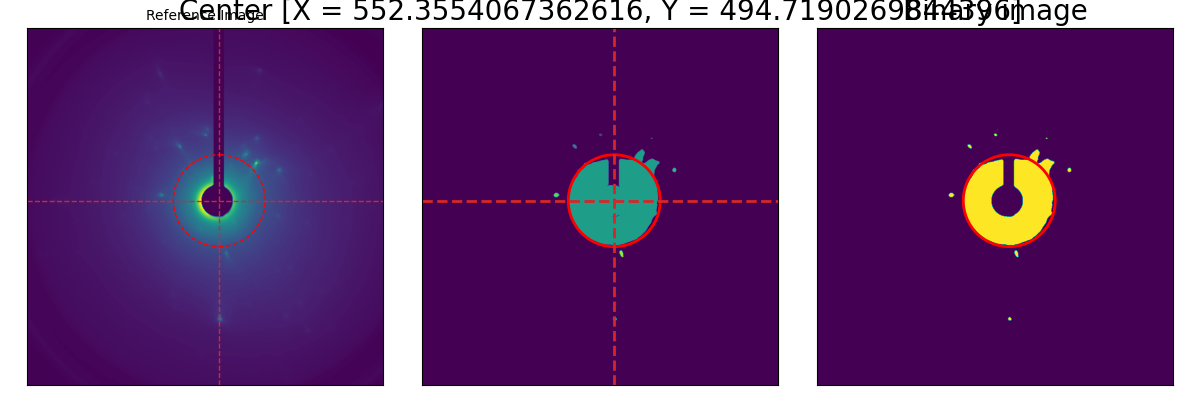

In [16]:
# Check your global variables by testing the center finding algorithm on one image 

test_x, test_y, _, _ = gued.finding_center_alg(data_array[0], plot=True)

### Find all Centers

In [17]:
help(gued.find_center_pool)

Help on function find_center_pool in module gued:

find_center_pool(data_array, plot=True, print_stats=False)
    Finds center of each image in the data array using concurrent.futures.ThreadPoolExecutor to quickly process
    many data files.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        array of image like data with shape Nx1024x1024
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default is set to True. When true, plots an image of the values for center_x and center_y with respect to pixel number
    print_stats (boolean): 
        Default is set to True. Prints the average value for center_x and center_y and prints the percent failure rate.
    
    GLOBAL VARIABLES:
    
    CENTER_GUESS (tuple): 
        initial guess for center position
    RADIUS_GUESS (int): 
        initial guess for the radius
    DISK_RADIUS (int): 
        value for disk radius used in mapping
    
    RETURNS:
    
    center_x (array):
        One-dimensional array of x values

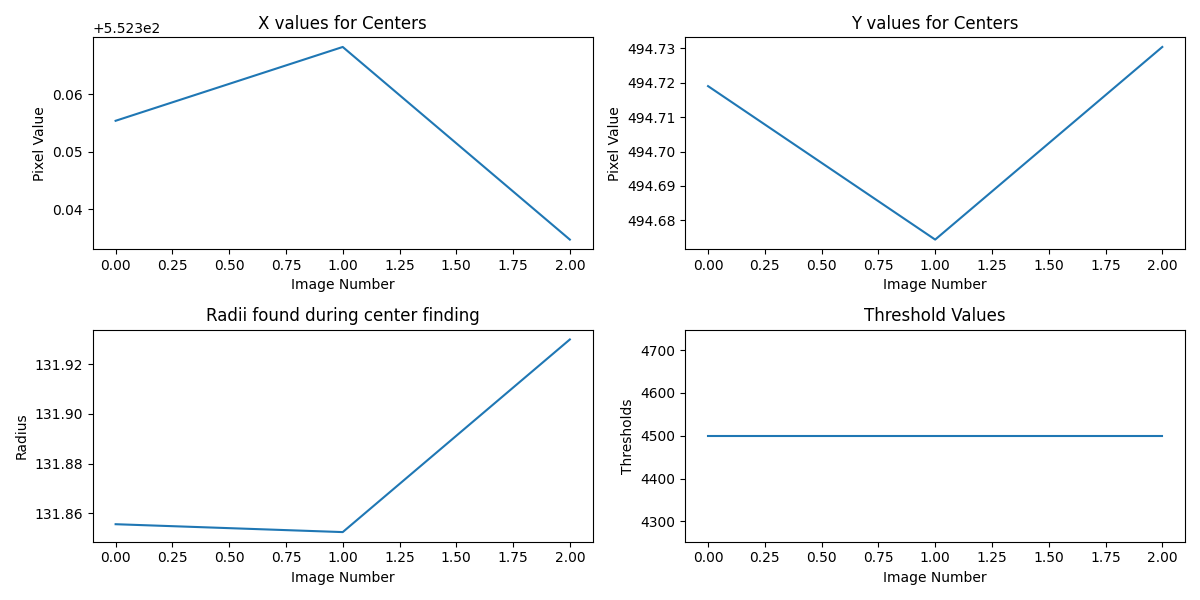

In [18]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)

## Reapply mask with nan values

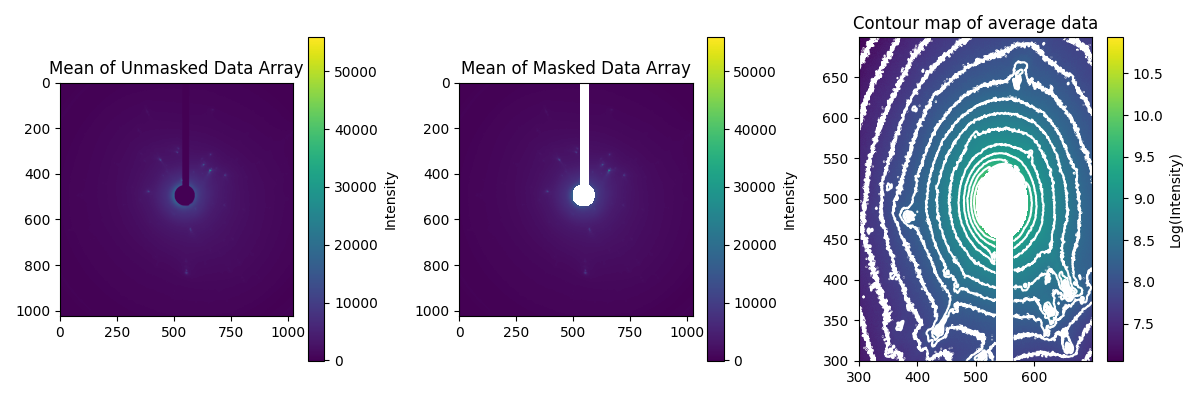

In [19]:
# Apply Mask
data_array = gued.apply_mask(data_array, fill_value=np.nan, add_rectangular=True, plot=True, print_vals=False)

## Remove Radial Outliers

In [20]:
help(gued.remove_radial_outliers_pool)

Help on function remove_radial_outliers_pool in module gued:

remove_radial_outliers_pool(data_array, centers, plot=False, return_pct=False)
    Removes instances of outlier pixels based on the radial average of the image. Runs the hidden function _remove_radial_outliers in parallel. 
    Works by first converting an individual array to polar coordinates and remaps to create an average image. Then performs a logical check on 
    the original image compared to interpolated image. 
    
    ARGUMENTS: 
    
    data_array (3d array):
        Original data 
    center (list):
        Can either be an average center value of form [x, y] or a list of centers of form [[x1,y1], [x2, y2], ...]
    
    OPTIONAL ARGUMENTS: 
    
    plot (boolean):
        default set to False. When true, plots an example of original data, the interpolated average image, and the cleaned image
    return_pct (boolean):
        Default set to False. When true, returns the percentage of pixels removed per image. 

Using all center values 
Removing radial outliers from all data


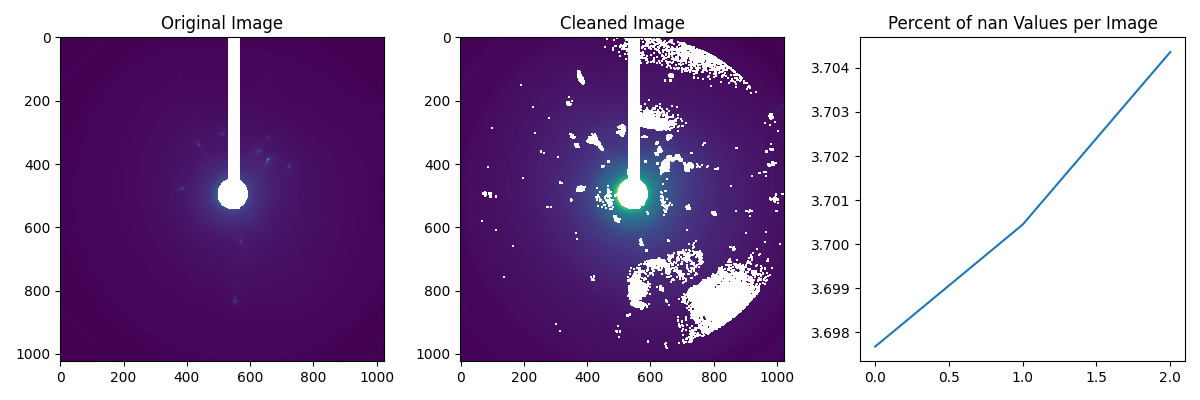

In [21]:
centers = list(zip(center_x, center_y))
#center = np.mean(center, axis=0)
cleaned_data = gued.remove_radial_outliers_pool(data_array, centers, plot=True)

data_array = cleaned_data 
del cleaned_data
#print(center)

## Apply Median Filter

In [22]:
help(gued.median_filter_pool)

Help on function median_filter_pool in module gued:

median_filter_pool(data_array, plot=True)
    Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing using the hidden function
    _median_filter.
    
    ARGUMENTS: 
    
    data_array (3d array):
        array of all images
    
    OPTIONAL ARGUMENTS:
    
    plot(boolean): Default set to True
        When true, plots an example of the original and of the filtered image
    
    RETURNS: 
        
    filtered_data (3d array):
        filtered data array of the same size as the input array



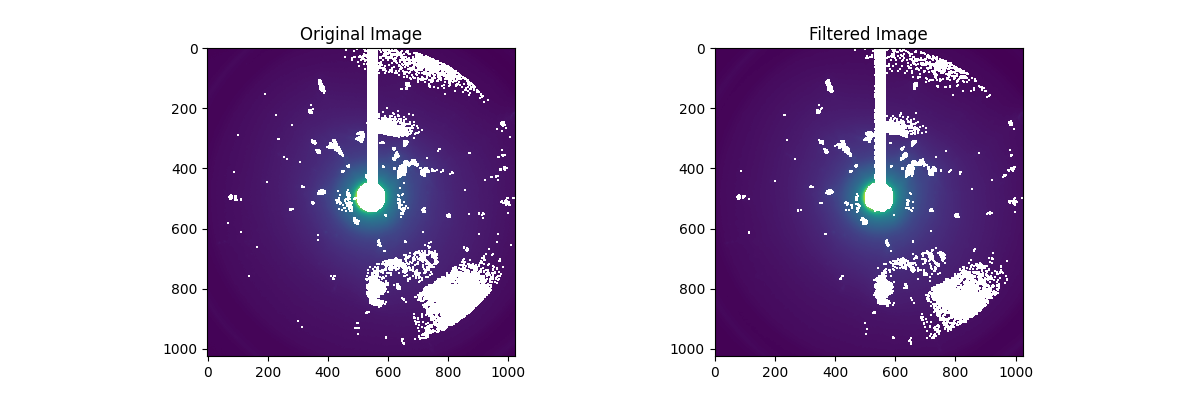

In [23]:
clean_data = gued.median_filter_pool(data_array, plot=True)

data_array = clean_data
del clean_data

## Get Azimuthal Average and Normalize

Using all center values 
Calculating azimuthal average for all data


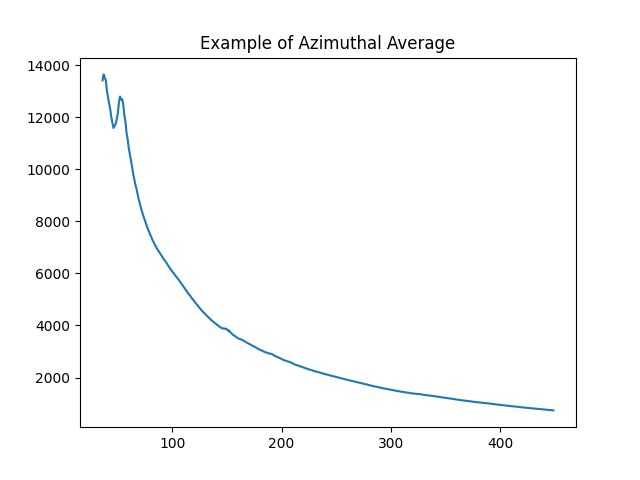

In [24]:
norm_data, norm_std = gued.get_azimuthal_average_pool(data_array, centers, normalize=True, plot=True)

## Plot dI/I lineouts

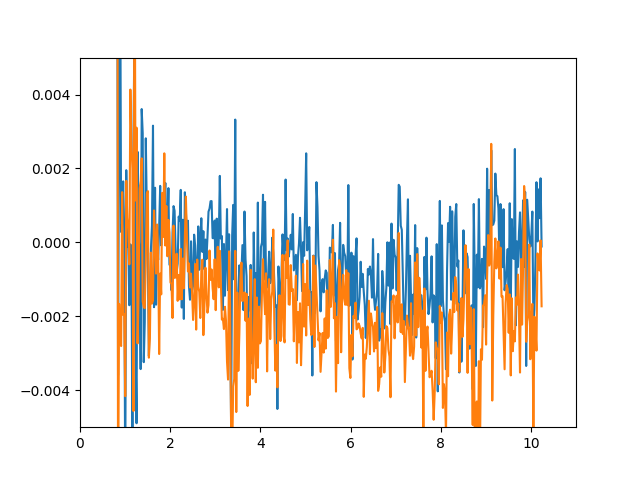

In [32]:
I_ref = norm_data[0]
dI_I = (norm_data-I_ref)/I_ref

# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0228 # S calibration in experiment
#s_cali = 0.02134
#posi_0    = 154.405 # The reference T0
posi_0 = 108.61
s = np.arange(0,len(norm_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

plt.figure()
plt.plot(s, dI_I[1])
plt.plot(s, dI_I[2])
plt.xlim(0,11)
plt.ylim(-0.005, 0.005)
plt.show()

## Save Data

In [ ]:
exp_label = "cf3i"
today = date.today()
print(today)

file_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\UV_IR_exp\\07222024\\Time_Scans\\"
file_name = file_path + f"{exp_label}_{today}.h5"
print(f"writing data to {file_name}")
group_name = "scan_2"
#group_name = "s4"
save_factor = 0
data_dictionary = {
    'clean_images': data_array,
    'stage_positions': stage_positions, 
    'centers': centers, 
    'total_counts': counts}

data_note = "Testing new processing with smoothed centers"
gued.save_data(file_name, group_name, (i+save_factor), data_dictionary, group_note=data_note)